In [26]:
!pip install windrose

In [28]:
!pip install graphviz

In [29]:
!pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('fivethirtyeight')
from windrose import WindroseAxes
import calendar
import warnings
warnings.filterwarnings("ignore")

#model building
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from IPython.display import SVG
from graphviz import Source
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor


# Data 

In [2]:
df = pd.read_csv(r"C:\Users\karth\OneDrive\Desktop\csv files\Inland Wind Farm Dataset1(WT1) (1).csv")
df.head()

Sequence No.     V      D  air density         I       S_b  \
0             1  7.96  138.9     1.140224  0.090452  0.266512   
1             2  8.19  140.6     1.140522  0.083028  0.286167   
2             3  7.20  139.3     1.140771  0.098611  0.339321   
3             4  6.81  137.4     1.141186  0.101322  0.375815   
4             5  5.09  137.5     1.141464  0.165029  0.303472   

   y (% relative to rated power)  
0                      39.315152  
1                      45.745455  
2                      38.212121  
3                      28.218182  
4                      12.721212

In [3]:
df.tail()

Sequence No.     V      D  air density         I       S_b  \
47537         47538  4.13  231.0     1.202602  0.075061  0.115917   
47538         47539  4.54  233.5     1.202525  0.063877  0.298002   
47539         47540  4.14  231.8     1.203006  0.079710  0.149803   
47540         47541  3.94  226.3     1.202999  0.114213  0.263033   
47541         47542  3.88  226.1     1.203409  0.074742  0.154067   

       y (% relative to rated power)  
47537                       0.793939  
47538                       2.557576  
47539                       2.503030  
47540                       0.454545  
47541                       0.381818

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47542 entries, 0 to 47541
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sequence No.                   47542 non-null  int64  
 1   V                              47542 non-null  float64
 2   D                              47542 non-null  float64
 3   air density                    47542 non-null  float64
 4   I                              47542 non-null  float64
 5   S_b                            47542 non-null  float64
 6   y (% relative to rated power)  47542 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.5 MB


# Exploratory Data Analysis

In [5]:
column_mapping = {
    "Sequence No.": "seq",
    "V": "velocity",
    "D": "direction",
    "air density": "air_density",
    "I": "turb_intensity",
    "S_b": "wind_shear",
    "y (% relative to rated power)": "relative_power"
}
df.rename(columns=column_mapping, inplace=True)
print(df.columns)

Index(['seq', 'velocity', 'direction', 'air_density', 'turb_intensity',
       'wind_shear', 'relative_power'],
      dtype='object')


In [6]:
df["month"] = np.nan
for i in range(12):
    m = (i + 8) if i < 5 else (i - 4)
    df.loc[i*3961: (i+1)*3961 - 1, "month"] = m

df["month"].fillna(7, inplace=True)


# Monthly Wind Speed Distribution

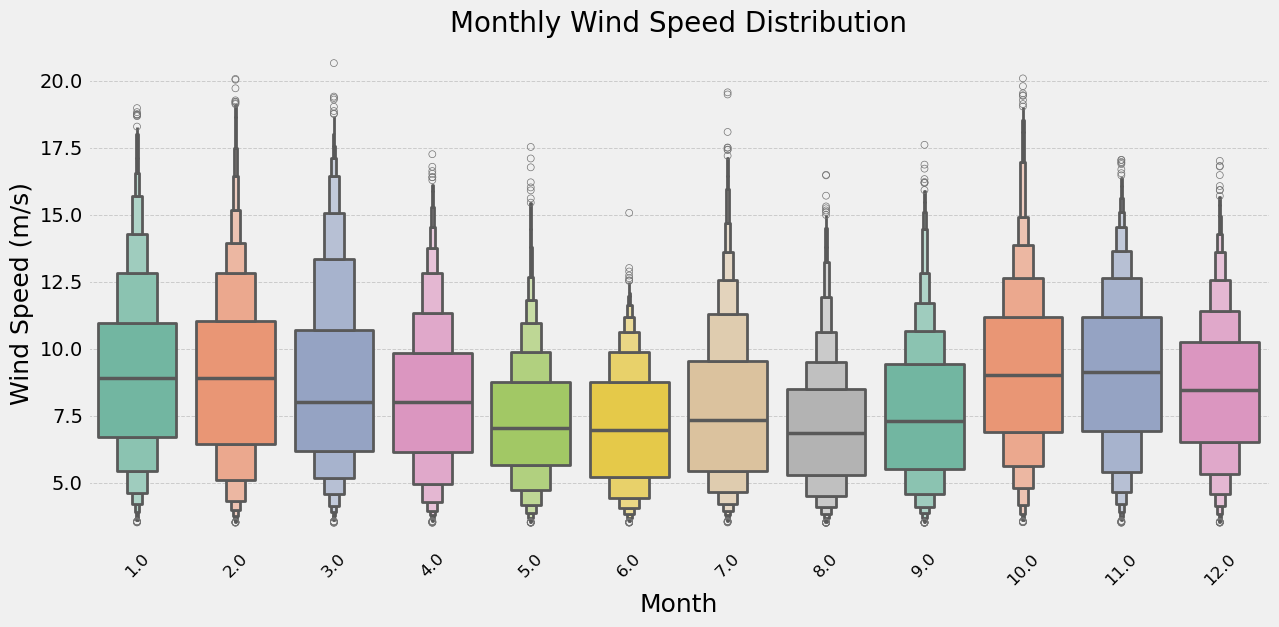

In [7]:
sns.catplot(x="month", y="velocity", kind="boxen", data=df, height=6, aspect=13/6, palette="Set2")

plt.xlabel('Month', fontsize=18)
plt.ylabel('Wind Speed (m/s)', fontsize=18)
plt.title('Monthly Wind Speed Distribution', fontsize=20, loc='center')

plt.xticks(rotation=45, fontsize=12)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()

# Let's plot wind speed in different Annual wind direction

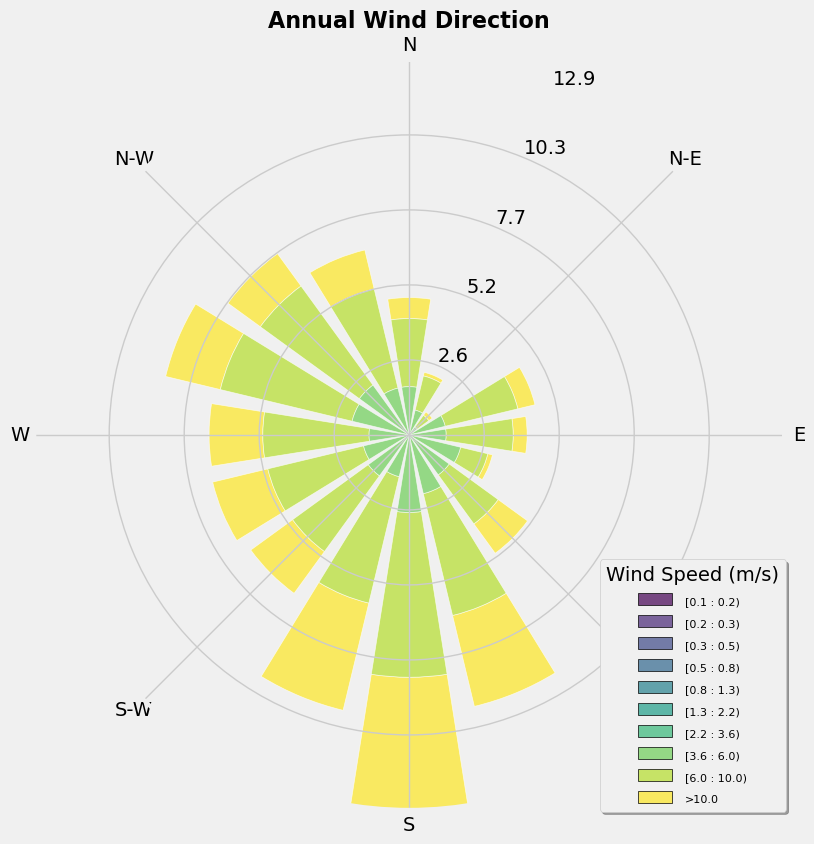

In [8]:
fig = plt.figure(figsize=(12, 10))

rect = [0.1, 0.1, 0.75, 0.75]  # Adjusted rect for better display
ax = WindroseAxes(fig, rect)

fig.add_axes(ax)

ax.bar(df['direction'], df['velocity'], normed=True, opening=0.8, 
       edgecolor='white', bins=np.logspace(-1, 1, 10), 
       colors=plt.cm.viridis(np.linspace(0, 1, 10)), alpha=0.7)

ax.set_title("Annual Wind Direction", fontsize=16, fontweight='bold')
ax.set_legend(title="Wind Speed (m/s)", loc="lower right", fontsize=12, shadow=True)
plt.show()

# Lets Plot Annual Power Curve By Month

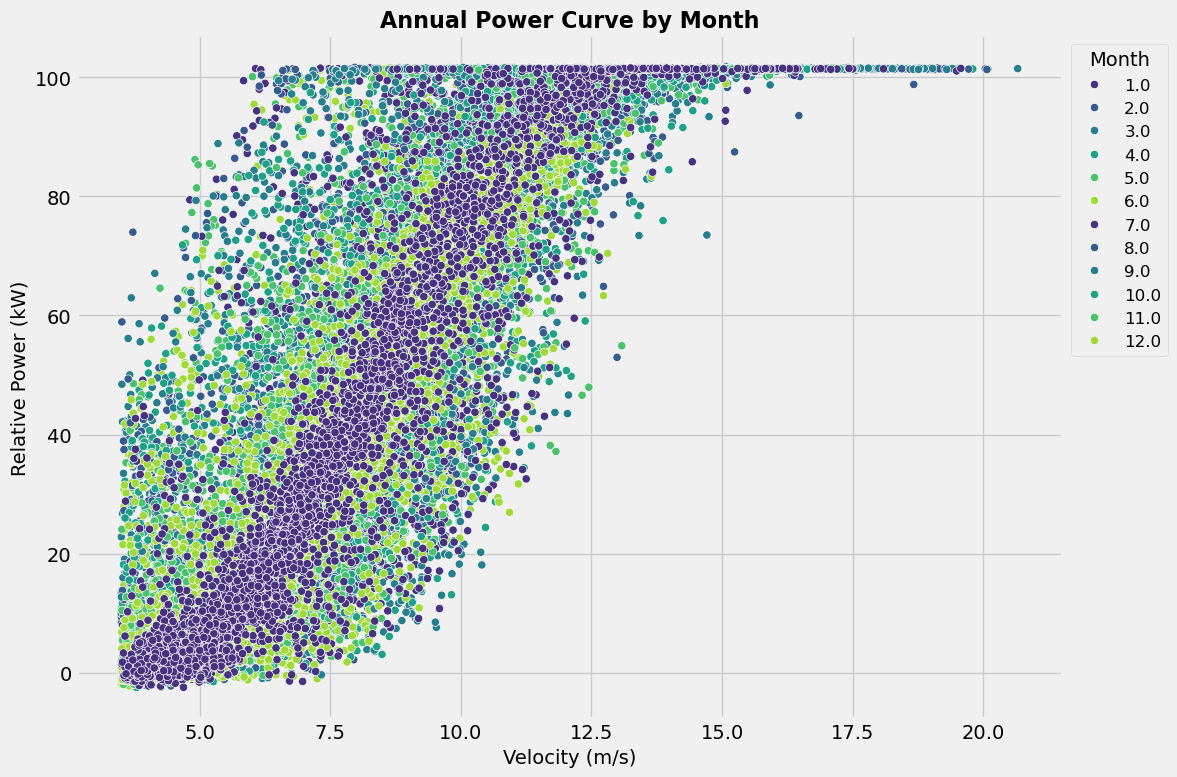

In [9]:
plt.figure(figsize=(12, 8))

palette = sns.color_palette("viridis", as_cmap=False)

sns.scatterplot(x=df.velocity, y=df.relative_power, hue=df.month, palette=palette, legend="full")

plt.xlabel("Velocity (m/s)", fontsize=14)
plt.ylabel("Relative Power (kW)", fontsize=14)

plt.title("Annual Power Curve by Month", fontsize=16, fontweight='bold')

plt.legend(title="Month", loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.show()


# Let's plot Monthly Power Curve

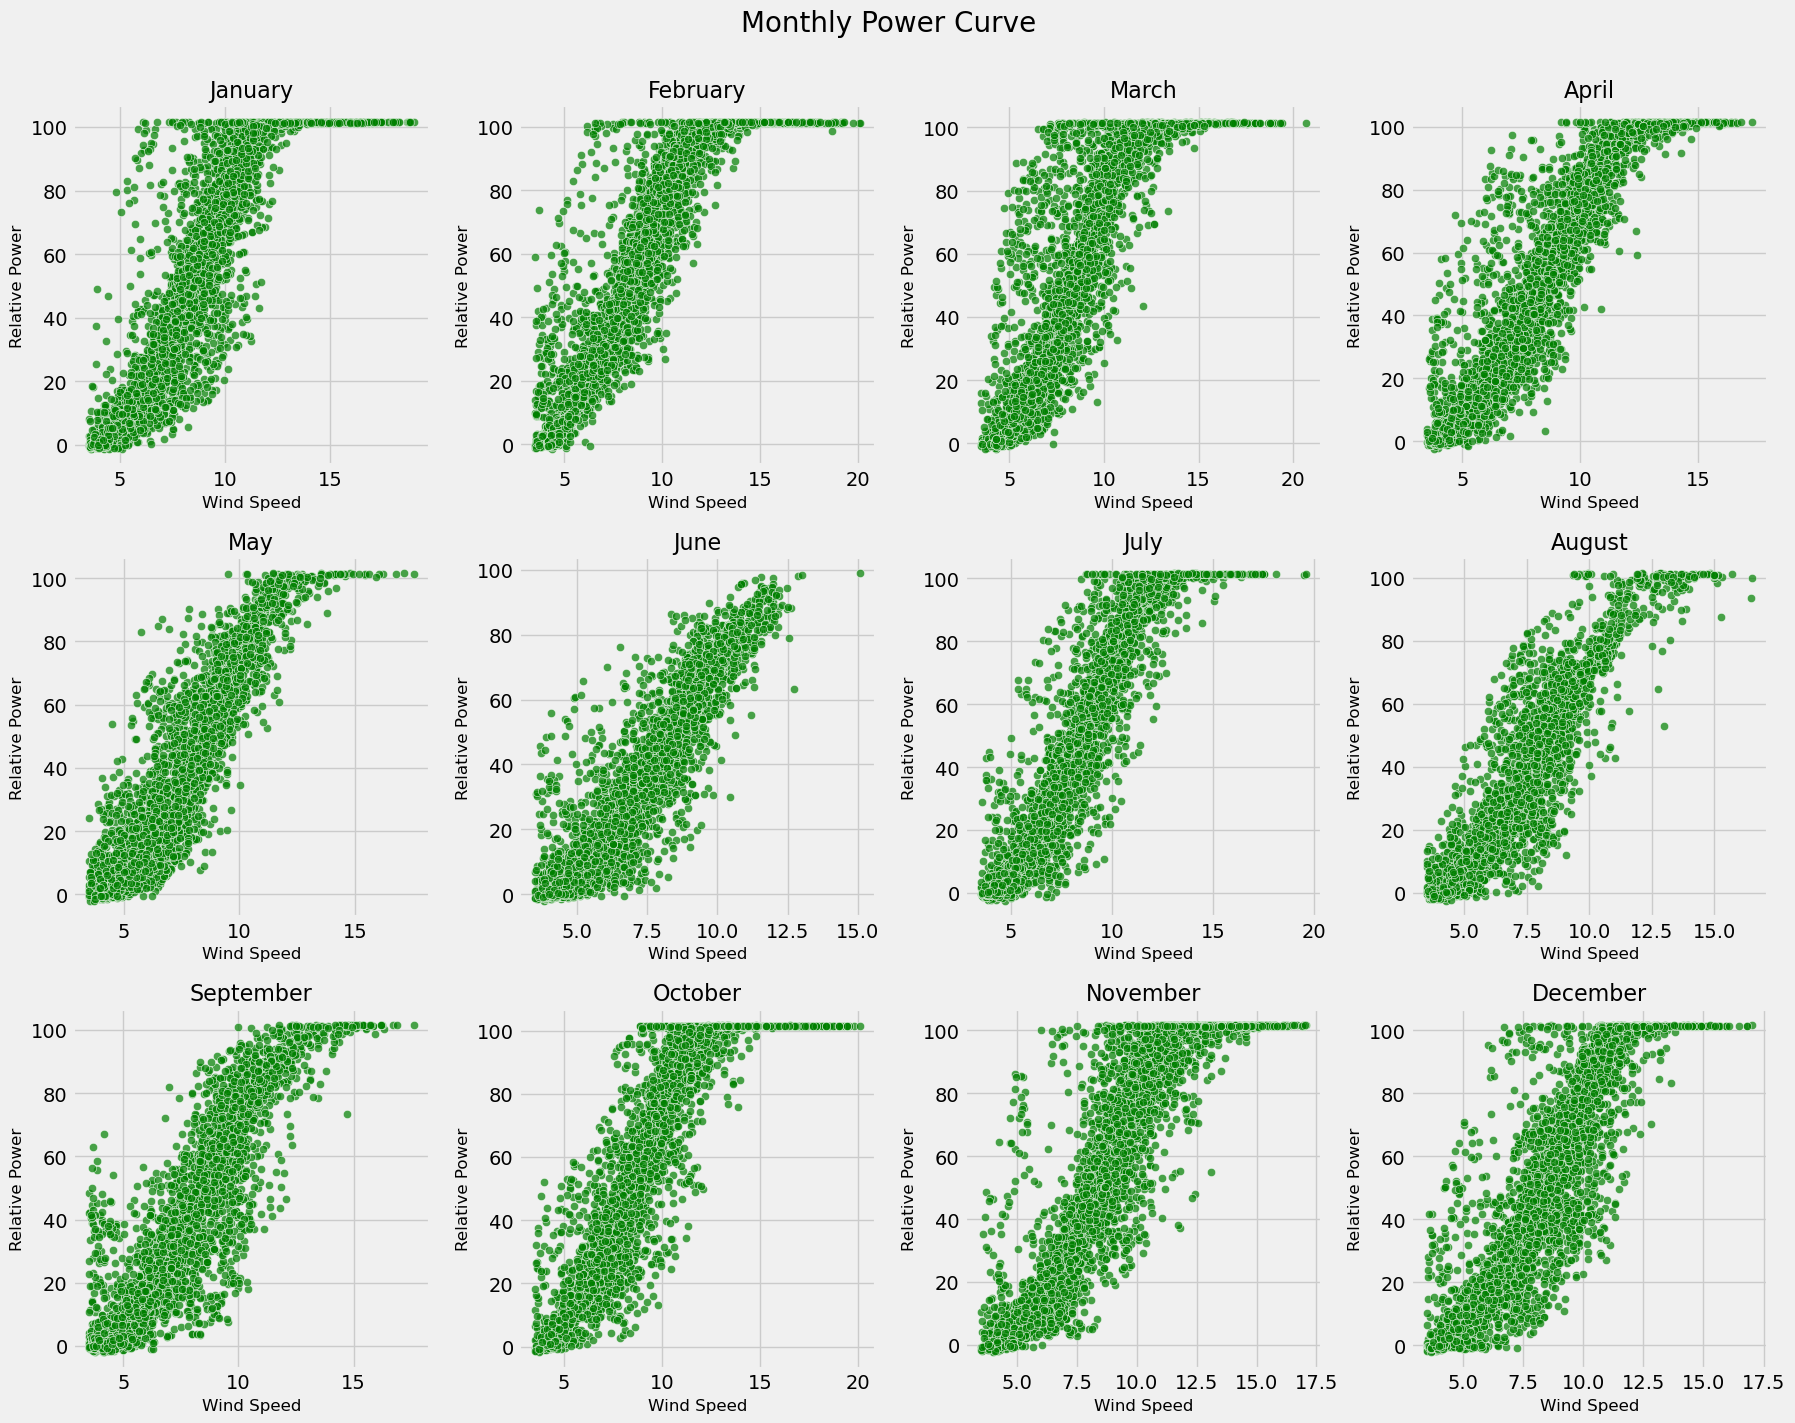

In [10]:
plt.figure(figsize=(18, 15))
plt.suptitle("Monthly Power Curve", fontsize=20, y=0.95)  

for i in range(1, 13):
    plt.subplot(3, 4, i)
    sns.scatterplot(x=df.velocity[df.month == i], 
                    y=df.relative_power[df.month == i], 
                    color="green", 
                    alpha=0.7) 
    plt.xlabel("Wind Speed", fontsize=12)
    plt.ylabel("Relative Power", fontsize=12)
    plt.title(calendar.month_name[i], fontsize=16)
    plt.grid(True)  
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


# Let's plot Monthly Air Density Distribution

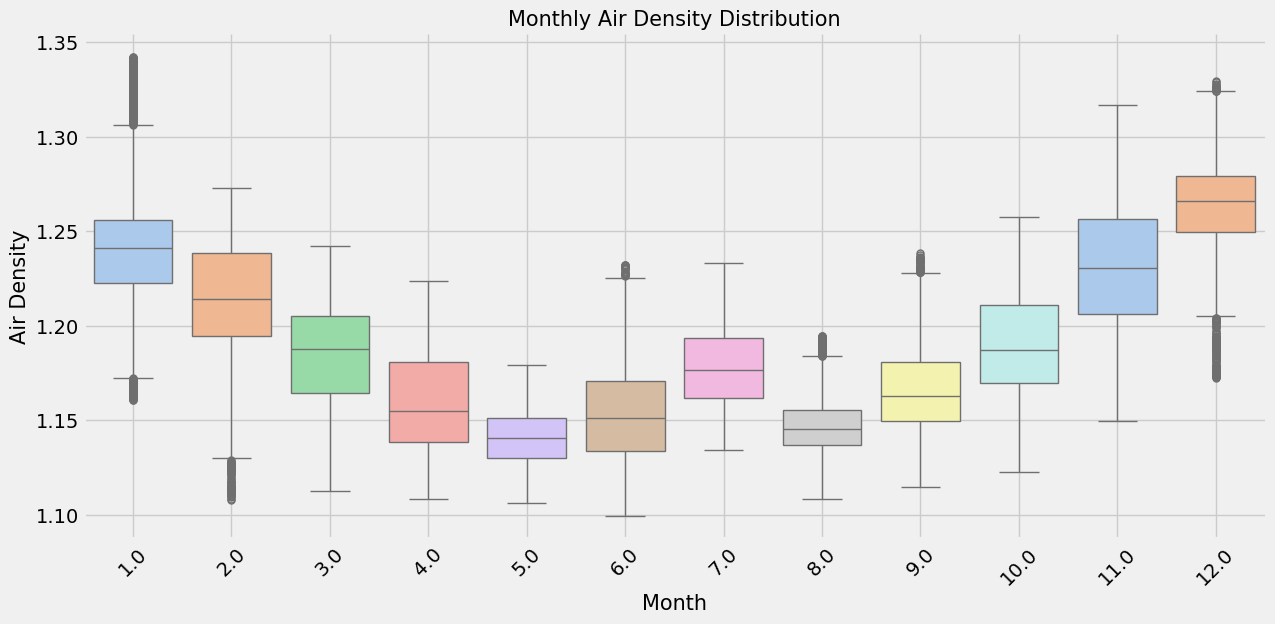

In [11]:
sns.catplot(x="month", y="air_density", kind="box", data=df, height=6, aspect=13/6, palette="pastel")

plt.xlabel('Month', fontsize=15)
plt.ylabel('Air Density', fontsize=15)
plt.title('Monthly Air Density Distribution', fontsize=15)

plt.xticks(rotation=45)
plt.grid(True)

plt.show()

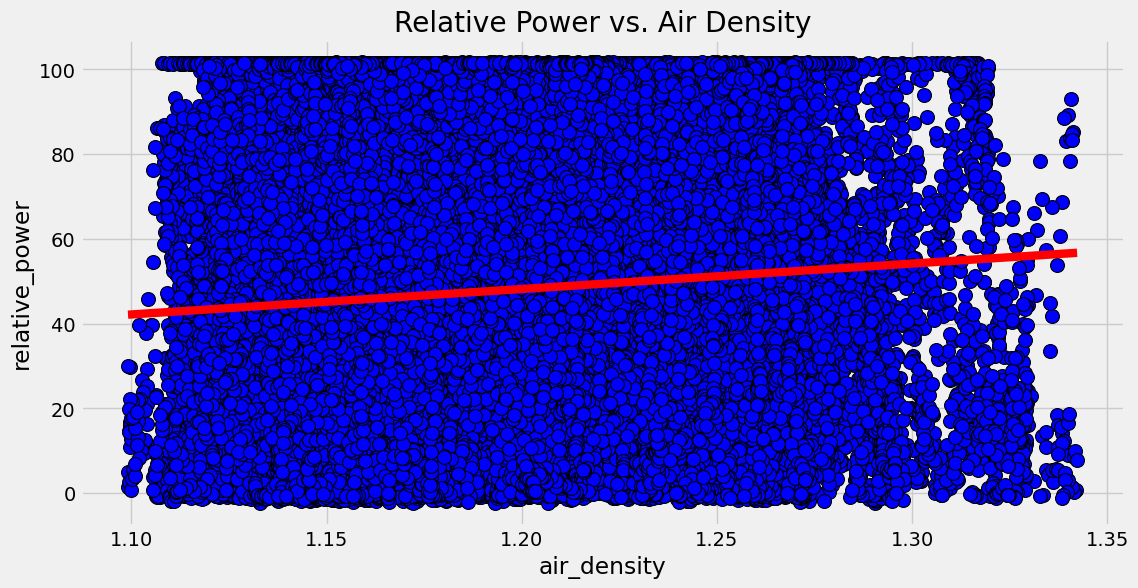

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df.air_density, y=df.relative_power, color='blue', marker='o', s=100, edgecolor='black')
plt.title("Relative Power vs. Air Density")
plt.xlabel("Air Density (kg/m³)")  
plt.ylabel("Relative Power (W)")  
plt.grid(True)  

sns.regplot(x=df.air_density, y=df.relative_power, scatter=False, color='red')

plt.show()


# Turbulence Intensity

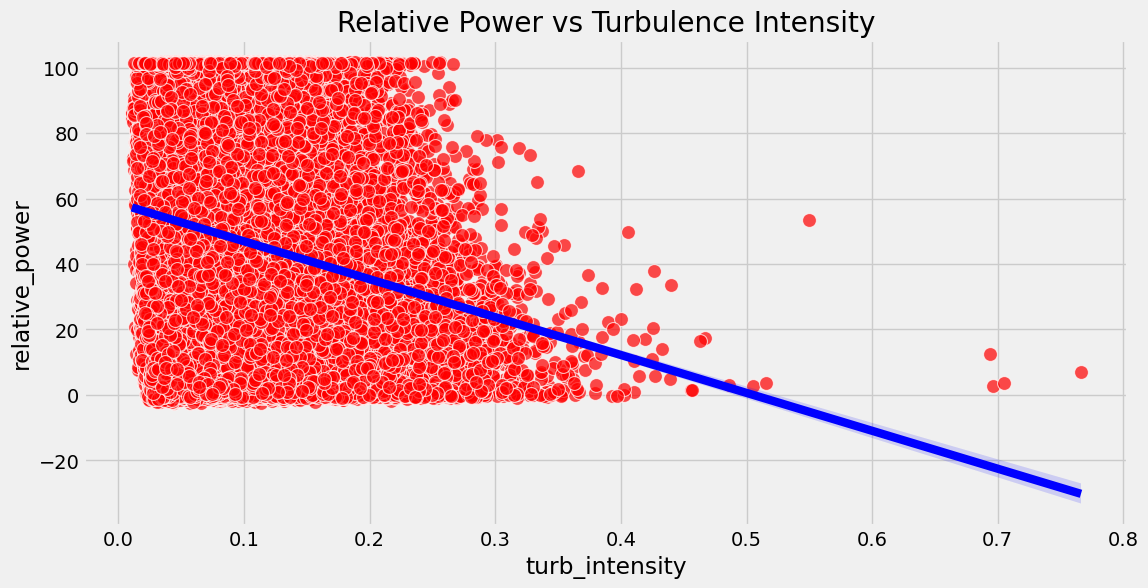

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(x=df.turb_intensity, y=df.relative_power, color="red", s=100, edgecolor='w', alpha=0.7)
plt.title("Relative Power vs Turbulence Intensity")
plt.xlabel("Turbulence Intensity")
plt.ylabel("Relative Power")
plt.grid(True)

# Optional: If you want to fit a regression line
sns.regplot(x=df.turb_intensity, y=df.relative_power, scatter=False, color='blue')

plt.show()


# Wind Shear

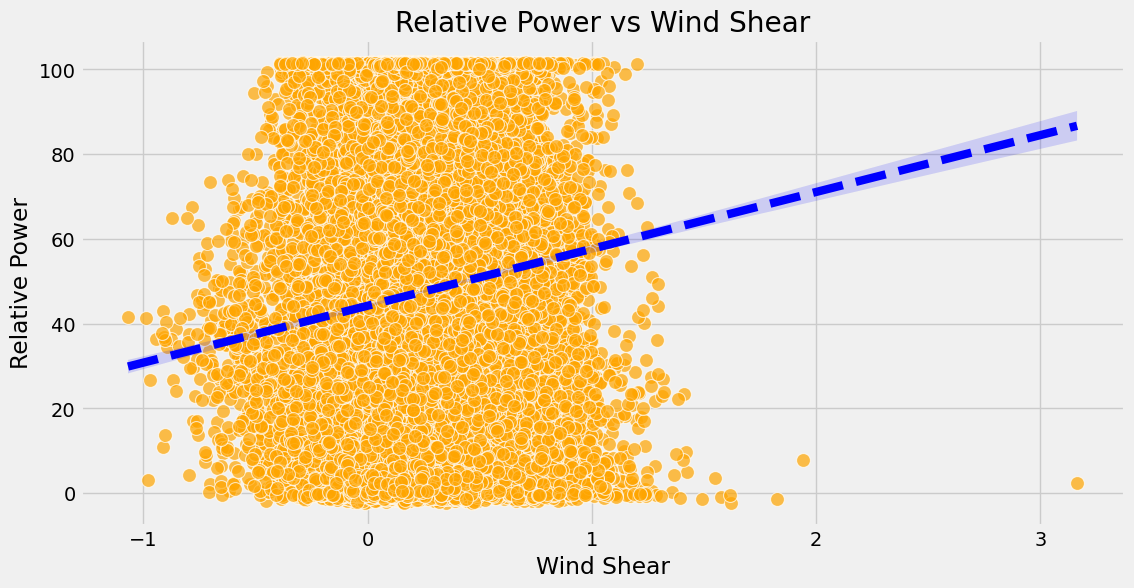

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df.wind_shear, y=df.relative_power, color="orange", marker='o', s=100, alpha=0.7)

sns.regplot(x=df.wind_shear, y=df.relative_power, scatter=False, color='blue', line_kws={"linestyle": '--'})

plt.title("Relative Power vs Wind Shear")
plt.xlabel("Wind Shear")
plt.ylabel("Relative Power")
plt.grid(True)
plt.show()

# Correlation and Paiwise plots

In [15]:
feats = ["velocity", "wind_shear", "turb_intensity", "air_density", "relative_power"]

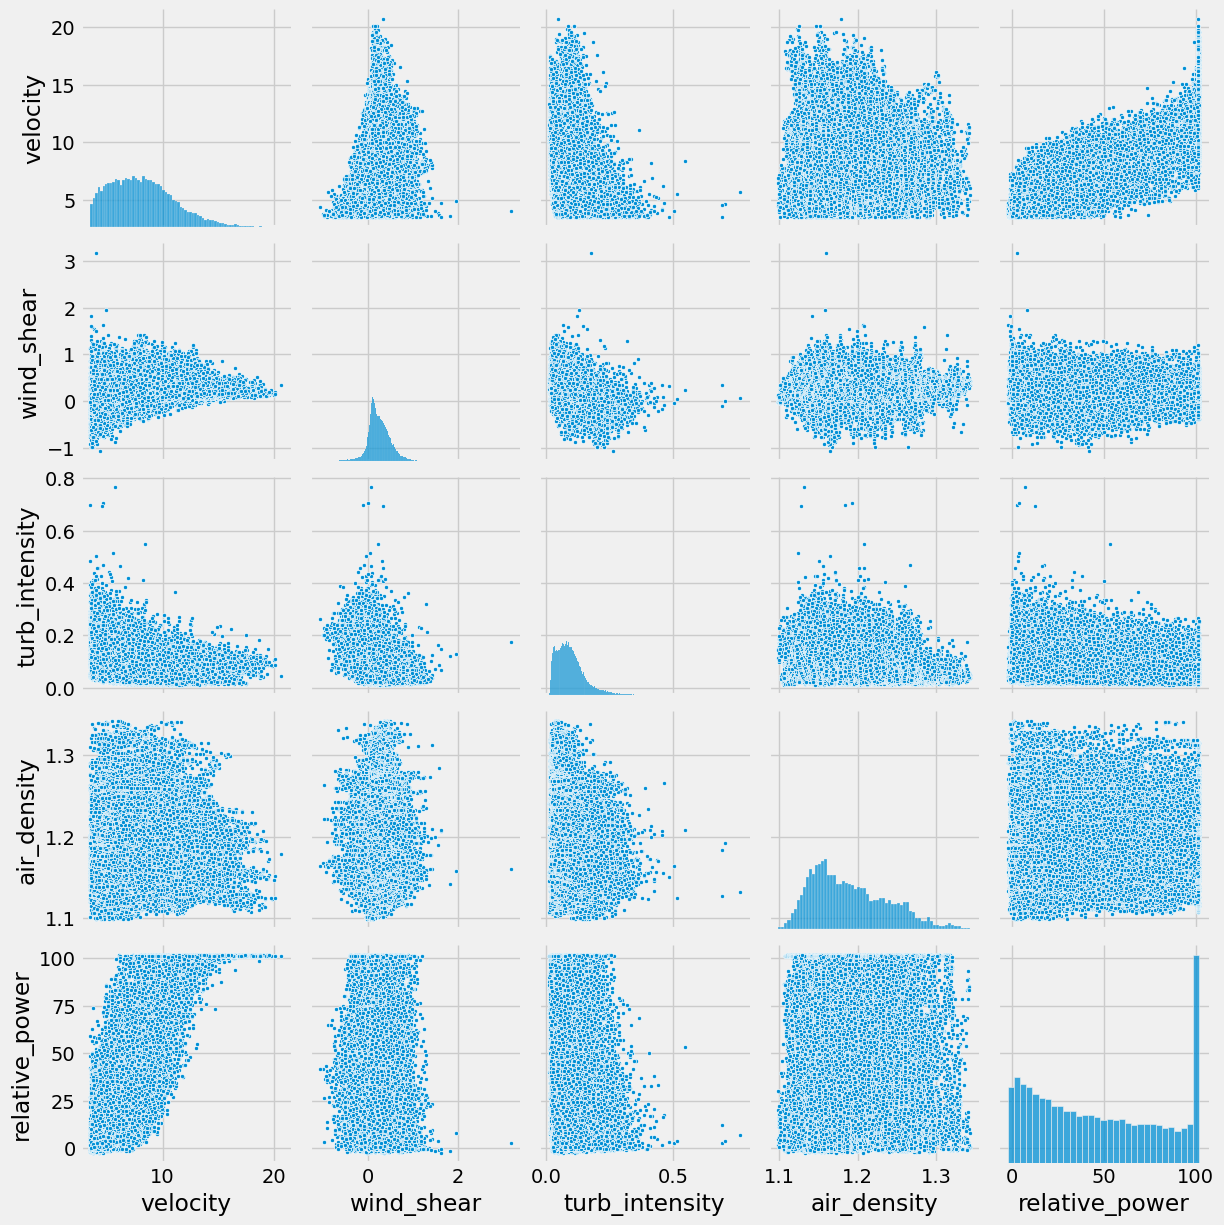

In [16]:
sns.pairplot(df[feats], markers='.');

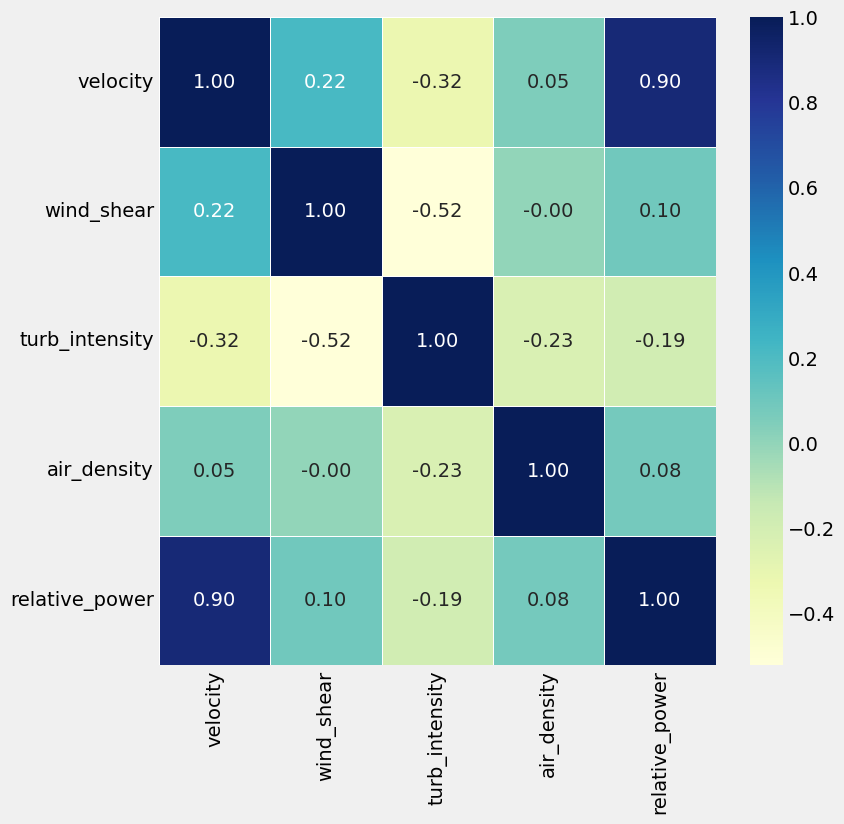

In [17]:
corr = df[feats].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.yticks(rotation=0);
plt.show()

# Data Preprocessing 

Cyclic Features 

In [18]:
num_months = 12
df["month_sin"] = np.sin((df.month - 1) * (2 * np.pi / num_months))

In [19]:
radians = np.radians(df.direction)

df["dir_sin"] = np.sin(radians)
df["dir_cos"] = np.cos(radians)

In [20]:
df.head()

seq  velocity  direction  air_density  turb_intensity  wind_shear  \
0    1      7.96      138.9     1.140224        0.090452    0.266512   
1    2      8.19      140.6     1.140522        0.083028    0.286167   
2    3      7.20      139.3     1.140771        0.098611    0.339321   
3    4      6.81      137.4     1.141186        0.101322    0.375815   
4    5      5.09      137.5     1.141464        0.165029    0.303472   

   relative_power  month  month_sin   dir_sin   dir_cos  
0       39.315152    8.0       -0.5  0.657375 -0.753563  
1       45.745455    8.0       -0.5  0.634731 -0.772734  
2       38.212121    8.0       -0.5  0.652098 -0.758134  
3       28.218182    8.0       -0.5  0.676876 -0.736097  
4       12.721212    8.0       -0.5  0.675590 -0.737277

In [21]:
df.tail()

seq  velocity  direction  air_density  turb_intensity  wind_shear  \
47537  47538      4.13      231.0     1.202602        0.075061    0.115917   
47538  47539      4.54      233.5     1.202525        0.063877    0.298002   
47539  47540      4.14      231.8     1.203006        0.079710    0.149803   
47540  47541      3.94      226.3     1.202999        0.114213    0.263033   
47541  47542      3.88      226.1     1.203409        0.074742    0.154067   

       relative_power  month     month_sin   dir_sin   dir_cos  
47537        0.793939    7.0  1.224647e-16 -0.777146 -0.629320  
47538        2.557576    7.0  1.224647e-16 -0.803857 -0.594823  
47539        2.503030    7.0  1.224647e-16 -0.785857 -0.618408  
47540        0.454545    7.0  1.224647e-16 -0.722967 -0.690882  
47541        0.381818    7.0  1.224647e-16 -0.720551 -0.693402

# Features Scaling

In [22]:
feats = ["velocity", "wind_shear", "turb_intensity", "air_density", "month_sin", "month", "dir_sin", "dir_cos"]

In [23]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df[feats] = min_max_scaler.fit_transform(df[feats])
df.head()

seq  velocity  direction  air_density  turb_intensity  wind_shear  \
0    1 -0.480186      138.9    -0.662035       -0.788857   -0.369050   
1    2 -0.453380      140.6    -0.659585       -0.808509   -0.359762   
2    3 -0.568765      139.3    -0.657538       -0.767261   -0.334643   
3    4 -0.614219      137.4    -0.654123       -0.760086   -0.317397   
4    5 -0.814685      137.5    -0.651839       -0.591451   -0.351584   

   relative_power     month  month_sin   dir_sin   dir_cos  
0       39.315152  0.272727       -0.5  0.657375 -0.753563  
1       45.745455  0.272727       -0.5  0.634731 -0.772734  
2       38.212121  0.272727       -0.5  0.652098 -0.758134  
3       28.218182  0.272727       -0.5  0.676876 -0.736097  
4       12.721212  0.272727       -0.5  0.675590 -0.737277

# Train Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df[feats], df.relative_power, test_size=0.05, random_state=42)

In [26]:
print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (45164, 8)
Test df shape: (2378, 8)


# Model Building

Baseline Model: Linear Regression

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LinearRegression(fit_intercept=True)
lm = model.fit(X_train_scaled, y_train)

lm.coef_


array([31.42187305, -1.86421153,  2.526813  ,  2.71020846,  0.44995598,
        0.49058725,  2.08179463, -2.22259195])

In [32]:
lm.intercept_

47.47015120646234

In [36]:
R_squared = lm.score(X_train, y_train)
print("R-squared:", R_squared)

R-squared: 0.25233799128510226


R-squared: -0.27


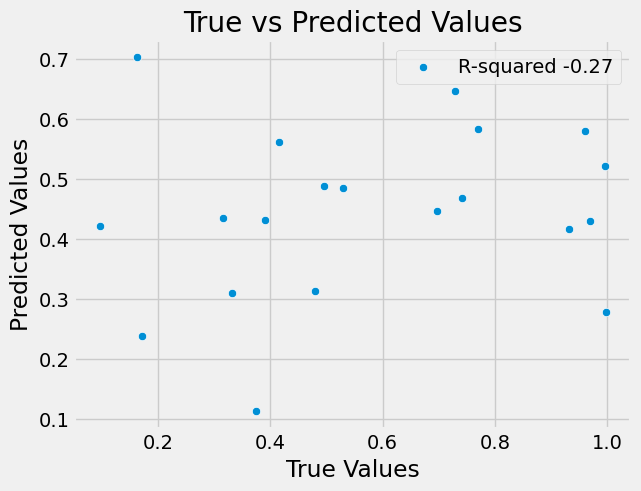

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Example dataset
data = pd.DataFrame({
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'feature3': np.random.rand(100),
    'feature4': np.random.rand(100),
    'feature5': np.random.rand(100),
    'feature6': np.random.rand(100),
    'feature7': np.random.rand(100),
    'feature8': np.random.rand(100),
    'extra_feature1': np.random.rand(100),  # Extra feature
    'extra_feature2': np.random.rand(100)   # Extra feature
})

# Target variable
target = np.random.rand(100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Keep only the first 8 features for training
X_train = X_train.iloc[:, :8]  # Select only the first 8 features
X_test = X_test.iloc[:, :8]     # Select only the first 8 features

# Optionally scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Linear Regression model
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

# Make predictions
predictions = lm.predict(X_test_scaled)

# Evaluate the model (e.g., R-squared)
from sklearn.metrics import r2_score
R_squared = r2_score(y_test, predictions)
print(f"R-squared: {R_squared:.2f}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=y_test, y=predictions, label=f"R-squared {R_squared:.2f}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.legend()
plt.show()


If the wind speed goes above rated output speed, we get only rated output power which is contstant and power does not increases linearly. Linear model fails to capture that and we need nonlinear models for that.

In [159]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 98.0566090641984


In [41]:
def rmsle_cv(model, X_train, y_train, n_folds=5, scoring_metric="neg_mean_squared_error"):
    
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                    scoring=scoring_metric, cv=kf))
    
    # Optionally print out RMSE for each fold
    print(f'RMSE per fold: {rmse}')
    
    return rmse


In [42]:
score = rmsle_cv(lm, X_train, y_train)
print(score.mean())

RMSE per fold: [0.29507039 0.31767551 0.32850563 0.33177592 0.30046069]
0.3146976282136561


# Polynomial Regression : Degrees 2 to 5

In [44]:
def polyfit(degree, x_train, y, x_test):
    poly_features = PolynomialFeatures(degree=degree)
    
    X_train_poly = poly_features.fit_transform(x_train)
    poly_model = LinearRegression()
    lm_poly = poly_model.fit(X_train_poly, y)
    
    R_squared = lm_poly.score(X_train_poly, y)
    predictions = lm_poly.predict(poly_features.fit_transform(x_test))
    
    return R_squared, predictions

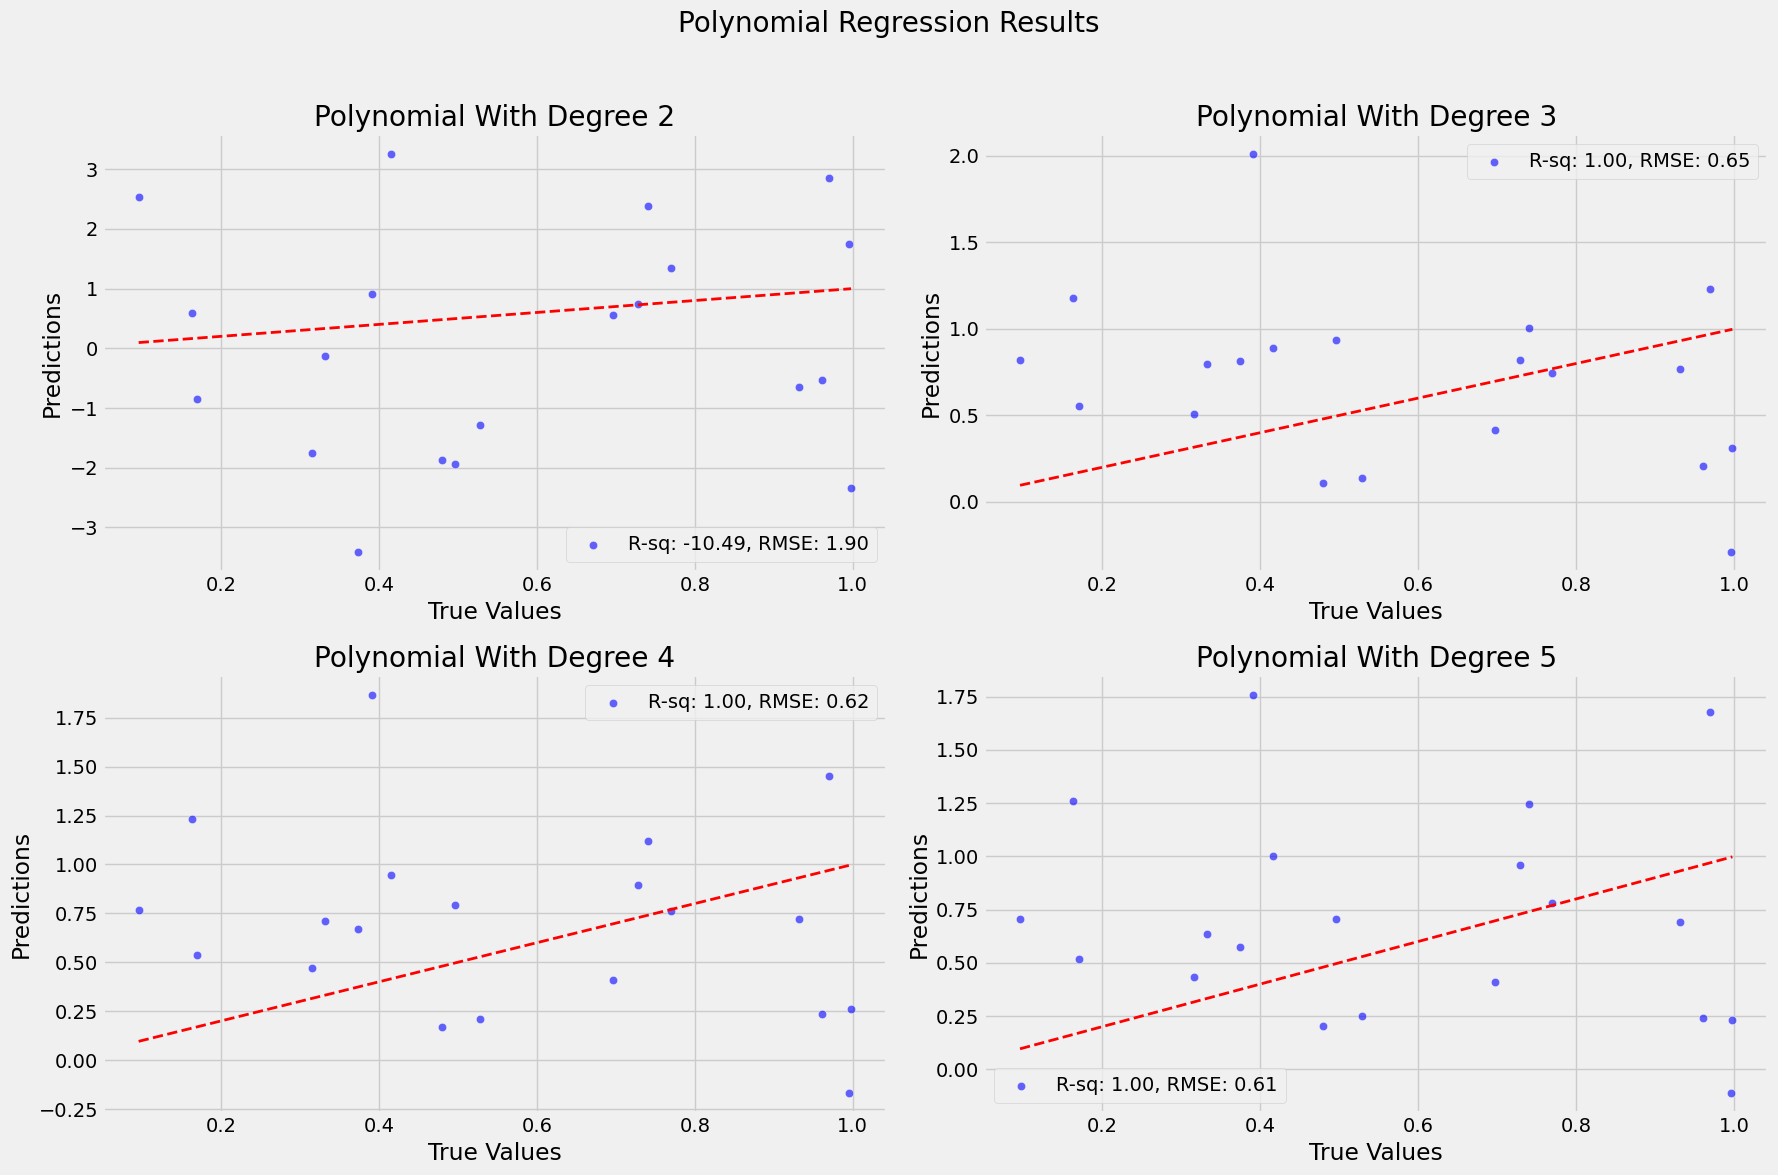

In [45]:
plt.figure(figsize=(18, 12))
plt.suptitle("Polynomial Regression Results", fontsize=20)

for i in range(2, 6):
    plt.subplot(2, 2, i - 1)
    plt.title('Polynomial With Degree {}'.format(i))
    
    r2, preds = polyfit(i, X_train, y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    sns.scatterplot(x=y_test, y=preds, label="R-sq: {:.2f}, RMSE: {:.2f}".format(r2, rmse), color='blue', alpha=0.6)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  
    
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


# Power Curve Estimation With Polynomial degree 4 Fit

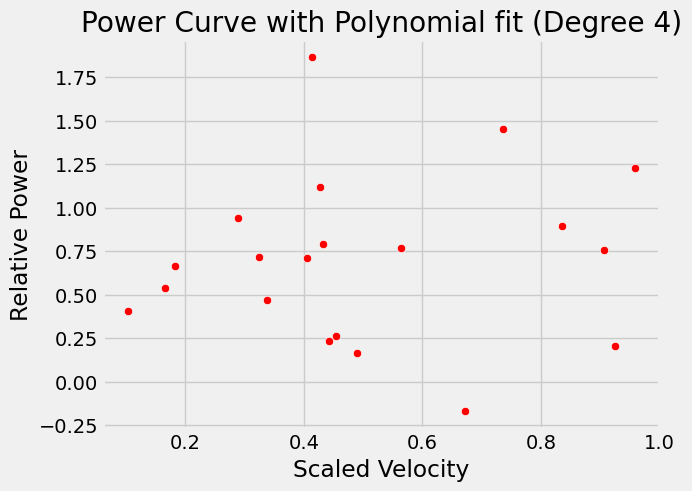

In [47]:
_ , preds =  polyfit(4, X_train, y_train, X_test)
sns.scatterplot(x = X_test.iloc[:,0], y = preds, color = "red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with Polynomial fit (Degree 4)");

# Lasso Regression

In [48]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

In [49]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression  # Example to create a dataset

# Example: create a regression dataset
X, y = make_regression(n_samples=100, n_features=10, noise=0.1)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

lasso = Lasso(max_iter=10000)
coefs = []

# Assuming alpha is defined; for example:
alpha = [0.1, 1.0, 10.0]  # Replace with your actual alpha values

for a in alpha:
    lasso.set_params(alpha=a)
    lasso.fit(X_normalized, y)
    coefs.append(lasso.coef_)

print(coefs)


[array([25.50172379, 50.22611956, 35.95785865, 68.4944174 , 66.1644667 ,
       76.48708773, 99.68243656, 63.85846586,  9.72260725, 19.99005762]), array([24.55719489, 48.93236065, 35.77183455, 68.04344021, 64.91710696,
       75.16868201, 98.60957966, 62.93554634,  9.02693911, 18.30251721]), array([15.1118618 , 35.99473297, 33.91163106, 63.53365872, 52.44349622,
       61.98460854, 87.88100501, 53.70635529,  2.07027093,  1.42709322])]


Text(0, 0.5, 'weights')

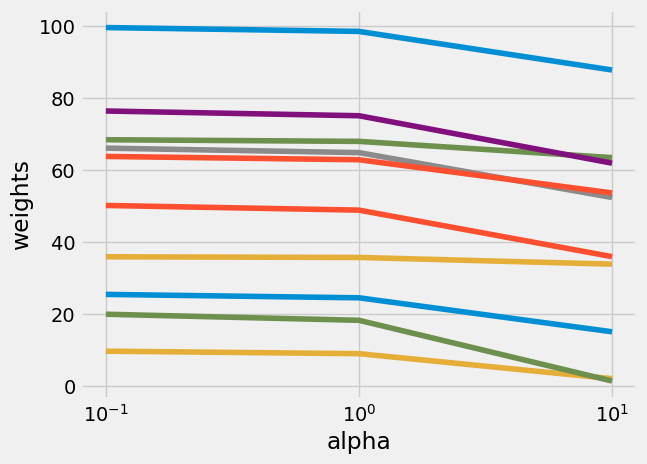

In [50]:
ax = plt.gca()
ax.plot(alpha, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Best alpha: 0.10782669045067864
Coefficients: [22.98141471 26.68891904 68.08835069 57.79638103 77.12873384 11.4785998
  3.46033344  8.13080895]
Test score (R^2): 0.9999809376857351
Best model coefficients:
Feature 0    22.981415
Feature 1    26.688919
Feature 2    68.088351
Feature 3    57.796381
Feature 4    77.128734
Feature 5    11.478600
Feature 6     3.460333
Feature 7     8.130809
dtype: float64


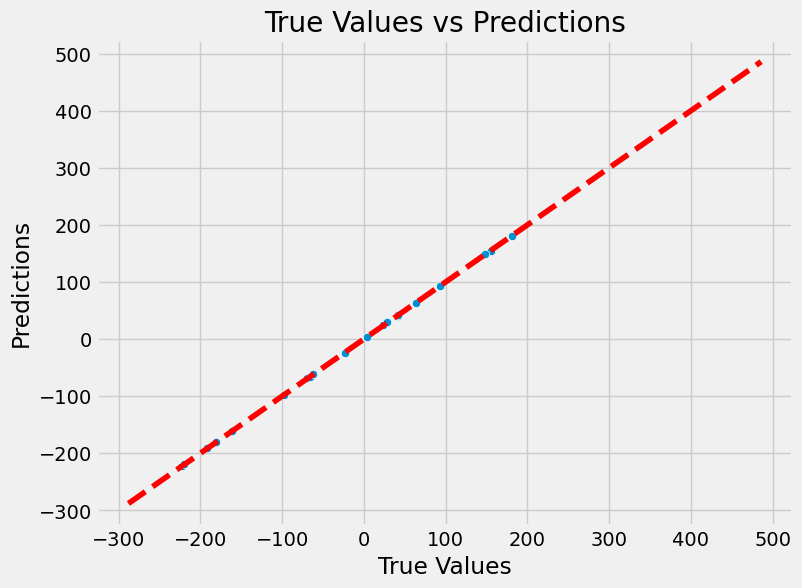

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# Step 1: Create a sample regression dataset
X, y = make_regression(n_samples=100, n_features=8, noise=0.1, random_state=42)

# Define feature names
feats = [f'Feature {i}' for i in range(X.shape[1])]

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize the training data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Step 4: Initialize and fit LassoCV
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000)
lassocv.fit(X_train_normalized, y_train)

# Step 5: Output the best alpha and coefficients
print(f"Best alpha: {lassocv.alpha_}")
print("Coefficients:", lassocv.coef_)

# Optional: Fit a Lasso model with the best alpha
lasso = Lasso(alpha=lassocv.alpha_, max_iter=100000)
lasso.fit(X_train_normalized, y_train)

# Step 6: Evaluate the model on the test set
test_score = lasso.score(X_test_normalized, y_test)
print(f"Test score (R^2): {test_score}")

# Step 7: Print best model coefficients with feature names
print("Best model coefficients:")
coefficients = pd.Series(lasso.coef_, index=feats)
print(coefficients)

# Step 8: Plot true values vs predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=lasso.predict(X_test_normalized))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs Predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Reference line
plt.show()


# RandomForest Regression

In [55]:
Rforest = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=100, 
                                min_samples_split=2, max_features='auto', 
                                min_impurity_decrease=None)

Rforest = RandomForestRegressor(max_features='sqrt')
Rforest.fit(X_train, y_train)

score = rmsle_cv(Rforest, X_train, y_train)
print(score.mean())

RMSE per fold: [78.84679844 82.01895398 56.65905889 66.17554526 98.47662593]
76.43539649992849


In [56]:
print("R-squared:", Rforest.score(X_train, y_train))

R-squared: 0.9648275537217077


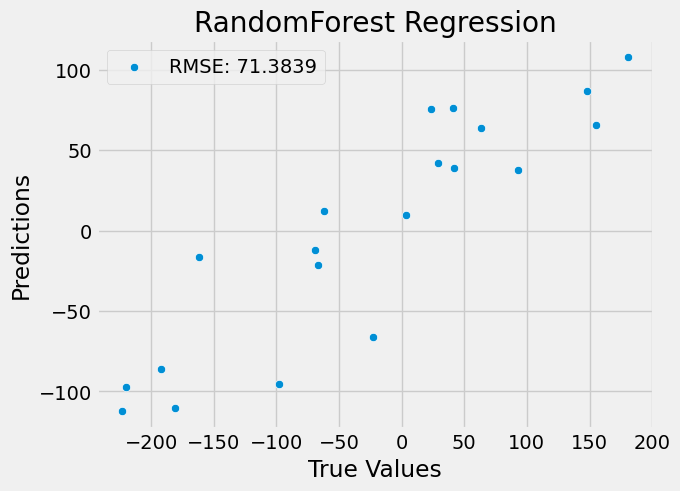

In [57]:
predictions = Rforest.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))

sns.scatterplot(x=y_test, y=predictions, label=f"RMSE: {rmse:.4f}")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("RandomForest Regression");
plt.legend()  
plt.show()


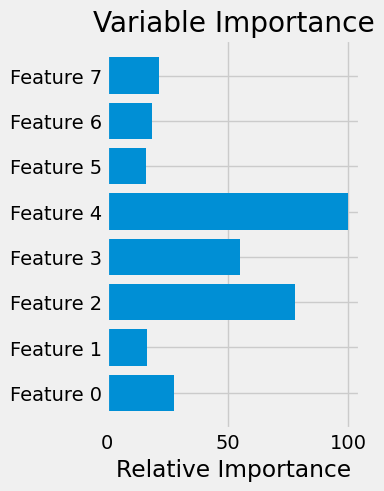

In [58]:
feature_importance = Rforest.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

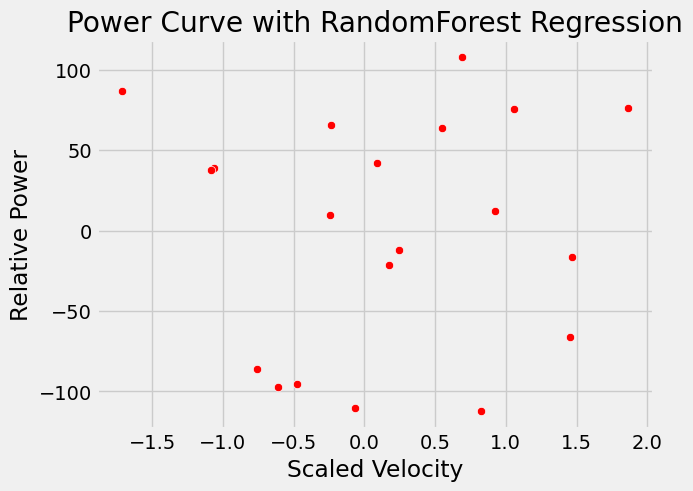

In [60]:
sns.scatterplot(x=X_test[:, 0], y=predictions, color="red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with RandomForest Regression")
plt.grid(True)  
plt.show()


# Gradient Boosting Regression

In [62]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1],
    'loss': ['squared_error'] 
}

model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=2, cv=3)
model.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=2,
             param_grid={'learning_rate': [0.1], 'loss': ['squared_error'],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [500, 750, 1000]})

In [63]:
print('Gradient boosted tree regression...')
print("Best parameters found: ", model.best_params_)

Gradient boosted tree regression...
Best parameters found:  {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 500}


In [64]:
params = {'n_estimators': 1000, 'max_depth': 5,
          'learning_rate': 0.1, 'loss': 'squared_error'}
gboost = GradientBoostingRegressor(**params)
gboost.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=1000)

In [65]:
print("Test R-squared:", gboost.score(X_test, y_test))


Test R-squared: 0.3595039135443201


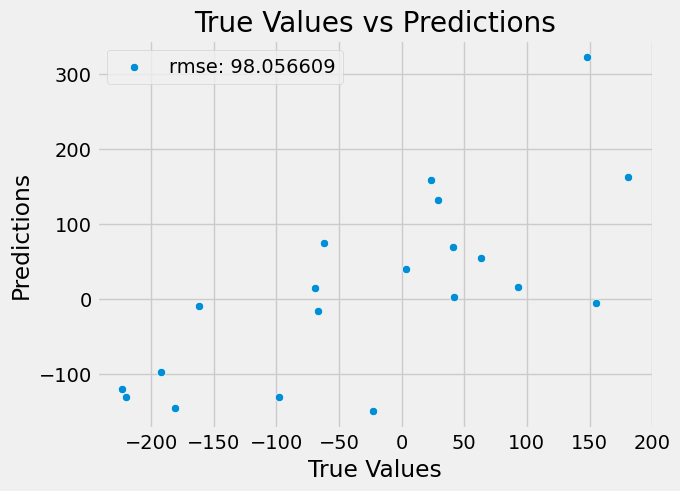

In [67]:

predictions = gboost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

sns.scatterplot(x=y_test, y=predictions, label="rmse: %f" % rmse)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.title("True Values vs Predictions")
plt.show()


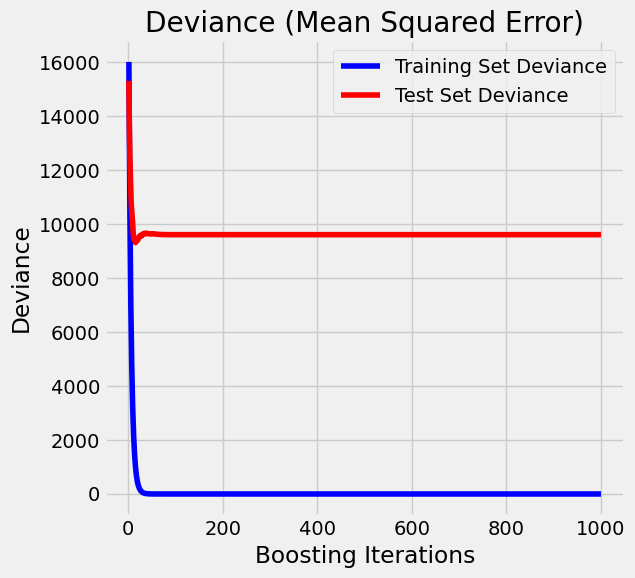

In [69]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

# Calculate test score for each stage
for i, y_pred in enumerate(gboost.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Plotting
plt.figure(figsize=(12, 6))

# Subplot for Deviance
plt.subplot(1, 2, 1)
plt.title('Deviance (Mean Squared Error)')
plt.plot(np.arange(params['n_estimators']) + 1, gboost.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

plt.tight_layout()
plt.show()


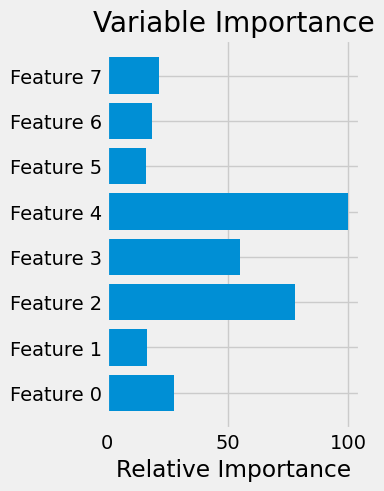

In [71]:
Feature_importance = gboost.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


Text(0, 0.5, 'Relative Power')

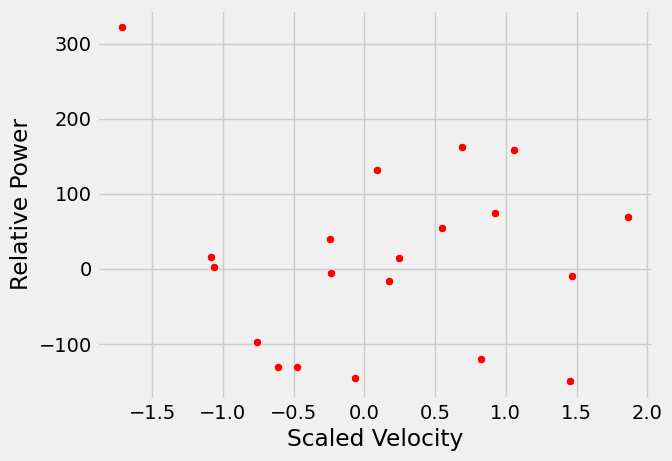

In [72]:
sns.scatterplot(x = X_test[:, 0], y = predictions, color = "red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")

# XGBoost Regression

In [74]:
param_grid = {'min_child_weight':[1,2,3],
          'n_estimators':[1000],
          'max_depth': [6,8,10],
          'subsample': [0.8],
          'gamma':[0],
          'reg_alpha':[0],
          'reg_lambda':[0]
         }

In [75]:
xgb = XGBRegressor()
model = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=2, cv=2)
model.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=2,
             param_grid={'gamma': [0], 'max_depth': [6, 8, 10],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [1000],
                         'reg_alpha': [0], 'reg_lambda': [0],
                         'subsample': [0.8]})

In [76]:
print('Extreme Gradient boosted tree regression...')
print('Best Params:')
print(model.best_params_)

Extreme Gradient boosted tree regression...
Best Params:
{'gamma': 0, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}


In [77]:
xgboost = XGBRegressor(gamma=0,                 
                 learning_rate=0.01,
                 max_depth=8,
                 min_child_weight=3,
                 n_estimators=1000,                                                                    
                 reg_alpha=0,
                 reg_lambda=0,
                 subsample=0.8,
                 seed=42) 

In [78]:
xgboost.fit(X_train,y_train);

In [79]:
print("R-squared:", xgboost.score(X_train, y_train))

R-squared: 0.9993221889776431


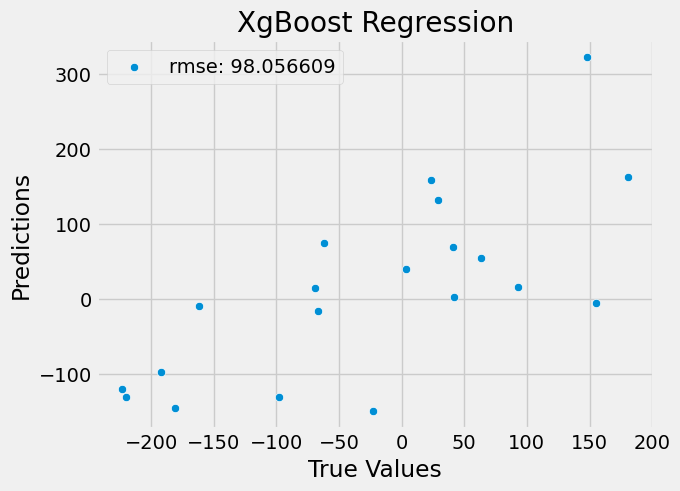

In [81]:
sns.scatterplot(x=y_test, y=predictions, label="rmse: %f" % rmse)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("XgBoost Regression");
plt.legend()


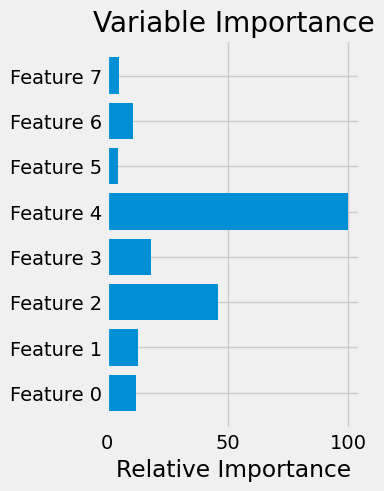

In [83]:
feature_importance = xgboost.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

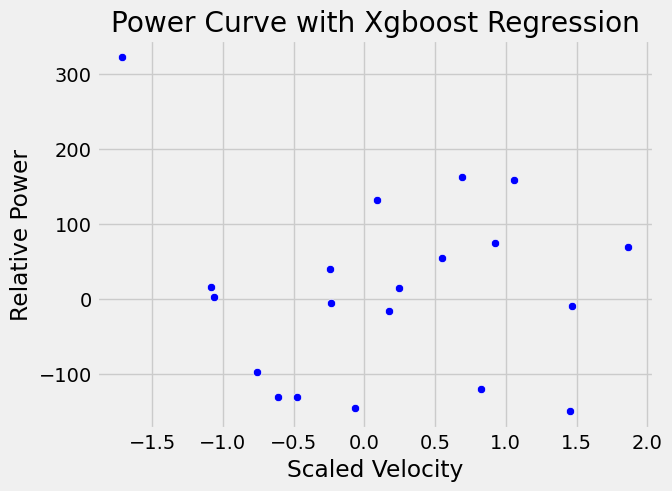

In [85]:
sns.scatterplot(x=X_test[:, 0], y=predictions, color="blue")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with Xgboost Regression")
plt.show()
